In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import numpy as np
from IPython.display import YouTubeVideo

import requests
import json

import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from scipy.signal import peak_prominences
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import torch.optim as optim

2025-03-20 20:28:34.991331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = r"/Users/scottmerrill/Documents/UNC/MultiModal/VMR/Youtube8m"

In [4]:
filenames = os.listdir(path + '/video')
file_name = filenames[0]

### Read the frame-level data

In [5]:
def sample_dataset(filename):
    video_data = np.load(path + f'/video/{filename}')
    audio_data = np.load(path + f'/audio/{filename}')
    video_data = video_data[:,:1024] # we still need to do pca whitening so leaving this for now
    return torch.tensor(video_data), torch.tensor(audio_data)

### Transformer_class


In [6]:
class Transformer(nn.Module):
    def __init__(self, input_dim=1024, embed_dim=512, num_heads=8, num_layers=2, max_seq_len=50):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, embed_dim)  # Project input to embedding dim
        self.pos_encoder = self._generate_sinusoidal_positional_encoding(max_seq_len, embed_dim)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads), num_layers=num_layers)
        self.output_proj = nn.Linear(embed_dim, embed_dim)  # Project to final embedding

    def _generate_sinusoidal_positional_encoding(self, max_len, embed_dim):
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # Shape: (1, max_len, embed_dim)

    def forward(self, x, mask):
        x = self.input_proj(x)  # Shape: (seq_len, embed_dim)
        seq_len = x.size(0)
        x = x + self.pos_encoder[:, :seq_len, :].squeeze(0).to(x.device)
        x = self.transformer(x.unsqueeze(1), src_key_padding_mask=mask).squeeze(1)
        x = x.mean(dim=0)  # Aggregate sequence to fixed-size embedding
        return self.output_proj(x)

### Load Video

In [7]:
video_features, audio_features = sample_dataset(file_name)

### Create Segments

### 1. Random

In [8]:
def get_segments(video_features, total_segments=9):
    segments = np.arange(0, video_features.shape[0], video_features.shape[0]//total_segments)
    segments = np.random.randint(0, video_features.shape[0], 10)
    segments = np.sort(segments)
    return segments

### 2. Optical Flow Based

In [9]:
# Function to calculate the optical flow using Euclidean distance between successive frames
def calculate_optical_flow_euclidean(embedding_seq):
    # Calculate the Euclidean distance between successive frames
    return np.linalg.norm(embedding_seq[1:] - embedding_seq[:-1], axis=1)


# Function to find local maxima and minima, ensuring that they are at least `min_dist` frames apart
def find_local_maxima_minima(flow, num_peaks=10, min_dist=10):
    # Find local maxima (peaks) and minima (valleys) in the optical flow
    maxima, _ = find_peaks(flow)
    minima, _ = find_peaks(-flow)  # Minima are the negative peaks

    # Combine maxima and minima
    all_peaks = np.concatenate((maxima, minima))

    # Sort all detected peaks
    all_peaks_sorted = np.sort(all_peaks)

    # Ensure that peaks are at least `min_dist` apart
    valid_peaks = [all_peaks_sorted[0]]  # Start with the first peak
    for i in range(1, len(all_peaks_sorted)):
        if all_peaks_sorted[i] - valid_peaks[-1] >= min_dist:
            valid_peaks.append(all_peaks_sorted[i])

    # Ensure we return no more than `num_peaks` peaks
    if len(valid_peaks) > num_peaks:
        valid_peaks = valid_peaks[:num_peaks]

    return np.array(valid_peaks)

# Function to create segments based on detected peaks
def create_segments_from_peaks(flow, num_segments=10, min_dist=10):
    # Find local maxima/minima to be used as segment boundaries
    peak_indices = find_local_maxima_minima(flow, num_peaks=num_segments, min_dist=min_dist)

    # Ensure that we always include the start (0) and end (len(flow)) of the video
    segment_boundaries = np.concatenate(([0], peak_indices, [len(flow)]))

    return segment_boundaries


# Function to compute a moving average of the flow
def moving_average(arr, window_size=5):
    """
    Compute the moving average of the given array using a window of size `window_size`.
    """
    return np.convolve(arr, np.ones(window_size) / window_size, mode='valid')

def merge_intervals(arr, minsize):
    # Ensure the array is sorted (if it is not already)
    arr = np.sort(arr)

    merged = [arr[0]]  # Start with the first element

    for i in range(1, len(arr)):
        # If the difference between consecutive elements is less than minsize, merge them
        if arr[i] - merged[-1] < minsize:
            continue  # Skip adding the current element (effectively merging)
        else:
            merged.append(arr[i])  # Otherwise, add the element to the merged list

    return np.array(merged)


def rank_averages(averages):
    # Get the indices that would sort the averages array in descending order
    sorted_indices = np.argsort(averages)[::-1]

    # Create an array to hold the ranks
    ranks = np.zeros_like(sorted_indices) + 1  # Initialize all ranks to 1

    # Assign ranks based on sorted order
    for rank, idx in enumerate(sorted_indices):
        ranks[idx] = rank + 1  # Assign the rank, +1 because ranking starts at 1

    return ranks

import numpy as np

def compute_segment_means(segments, other_array):
    """
    Computes the mean of `other_array` values for each segment defined by `segments`.
    If a segment extends beyond the bounds of `other_array`, the mean will be 0 for that segment.

    Parameters:
    - segments (np.array): Array of segment boundaries (must be in increasing order).
    - other_array (np.array): Array of values to calculate the mean over.

    Returns:
    - List of means for each segment.
    """
    # Length of the other_array
    array_length = len(other_array)

    averages = []

    # Process the middle segments
    for i in range(1, len(segments)):
        start_idx = segments[i-1]
        end_idx = segments[i]

        # Adjust the end index if it's out of bounds
        if end_idx > array_length:
            end_idx = array_length

        # If the range is valid (start < end), compute the mean; else, return 0
        if start_idx < end_idx:
            segment_mean = other_array[start_idx:end_idx].mean()
        else:
            segment_mean = 0

        averages.append(segment_mean)

    return averages

def optical_flow_segments(optical_flow, max_segments=10, min_frames=10):
    # calculate peaks and prominences
    peaks, _ = find_peaks(optical_flow)
    prominences = peak_prominences(optical_flow, peaks)[0]
    prominences = prominences.argsort()
    peak_index = peaks[prominences[-max_segments:]]
    peak_index.sort()

    # merge so they have a minimum distance of min_frames
    peak_index_final = merge_intervals(peak_index, min_frames)
    #peak_index_final.insert(0, 0)
    peak_index_final = np.insert(peak_index_final, 0, 0)
    peak_index_final = np.append(peak_index_final, len(optical_flow))
    return peak_index_final

In [10]:
# Calculate optical flow using cosine similarity
optical_flow_video = calculate_optical_flow_euclidean(video_features)
optical_flow_video = moving_average(optical_flow_video, window_size=20)
segments = optical_flow_segments(optical_flow_video, max_segments=4)

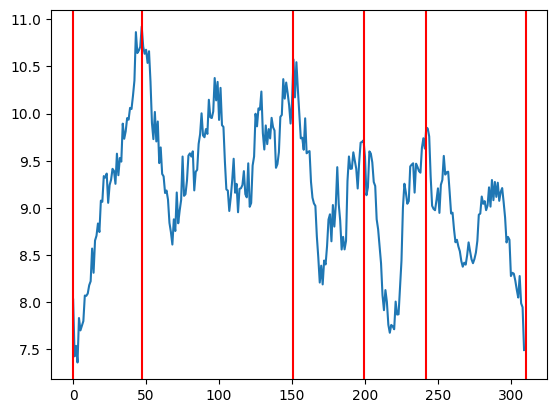

In [11]:
plt.plot(optical_flow_video)
for peak in segments:
    plt.axvline(peak, ymin=0, ymax=1, color='r')

### Pad video and audio segments to a max size of 50

In [12]:
def perform_feature_padding(video_features, audio_features, start_segment, end_segment, max_seq_len):
    vf = torch.tensor(video_features[start_segment:end_segment,:])
    af = torch.tensor(audio_features[start_segment:end_segment,:])

    pvf = torch.zeros(max_seq_len, 1024)
    pvf[:vf.shape[0], :] = vf

    paf = torch.zeros(max_seq_len, 128)
    paf[:af.shape[0], :] = af

    # Create mask (True for padding positions)
    mask = torch.arange(max_seq_len) >= vf.shape[0]
    mask = mask.unsqueeze(0)  # Convert to 2D (batch_size=1, seq_len)
    return pvf, paf, mask

start_segment, end_segment = segments[0], segments[1]
max_seq_len = 100
vpf, paf, mask = perform_feature_padding(video_features, audio_features, start_segment, end_segment, max_seq_len)

/var/folders/f5/796xkfr143jgq9b4ttxj_2pc0000gn/T/ipykernel_5577/1427386281.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vf = torch.tensor(video_features[start_segment:end_segment,:])
/var/folders/f5/796xkfr143jgq9b4ttxj_2pc0000gn/T/ipykernel_5577/1427386281.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  af = torch.tensor(audio_features[start_segment:end_segment,:])


### Now we can pass these to transformer

In [13]:
num_layers = 1
num_heads = 1

# max segment size of 100 frames

audio_model = Transformer(input_dim=128, embed_dim=256, num_heads=num_heads, num_layers=num_layers, max_seq_len=max_seq_len)
video_model = Transformer(input_dim=1024, embed_dim=256, num_heads=num_heads, num_layers=num_layers, max_seq_len=max_seq_len)

In [ ]:
audio_embedding = audio_model(paf, mask)
video_embedding = video_model(vpf, mask)
joint_embedding = torch.cat([audio_embedding, video_embedding])

### Triplet Loss

1.  L_{VA}
- Positive anchor corresponding to video, positive value for audio, negative audio sample

Choose segments which are at least somewhat the same length

In [1]:
# Function to find pairs with approximately equal differences
def find_matching_index_pairs(array1, array2, tolerance=5):
    # Calculate differences in array1 and array2
    array1_diffs = np.diff(array1)
    array2_diffs = np.diff(array2)

    matching_pairs = []

    # Loop through differences in array1
    for i, diff1 in enumerate(array1_diffs):
        # Find pairs of consecutive indices in array2 with similar differences
        for j, diff2 in enumerate(array2_diffs):
            if abs(diff1 - diff2) <= tolerance:  # If the difference is within the tolerance
                matching_pairs.append(((i, i + 1), (j, j + 1), diff1, diff2))

    return matching_pairs

In [2]:
def get_similar_length_segments(positive_segments, negative_segments, tolerance = 5):
    
    while True:
        matching_indexes = find_matching_index_pairs(positive_segments, negative_segments, tolerance=tolerance)
        tolerance += 5
        if len(matching_indexes) > 0:
            break
            
    # sample randomly for all segments within the tolerance band
    pos_segment, negative_segment, pos_time, neg_time = matching_indexes[np.random.randint(0, len(matching_indexes))]
    
    return pos_segment, negative_segment, pos_time, neg_time

In [3]:
positive_record_file = np.random.choice(filenames)
negative_record_file = np.random.choice(filenames)

positive_rgb, positive_audio = sample_dataset(positive_record_file)
negative_rgb, negative_audio = sample_dataset(negative_record_file)

positive_segments = get_segments(positive_rgb)
negative_segments = get_segments(negative_rgb)
pos_segment, negative_segment, pos_time, neg_time = get_similar_length_segments(positive_segments, negative_segments, tolerance = 5)
print(pos_segment, negative_segment, pos_time, neg_time)

NameError: name 'np' is not defined

In [772]:
# converting segment index to time in seconds
pos_start, pos_end = pos_segment
pos_start = positive_segments[pos_start]
pos_end = positive_segments[pos_end]
print(pos_start, pos_end)

# retrieving segment and padding it appropriately
pos_video, pos_audio, pos_mask = perform_feature_padding(positive_rgb, positive_audio, pos_start, pos_end, max_seq_len)

# computing embedding
positive_video_embedding = video_model(pos_video, pos_mask)
positive_audio_embedding = audio_model(pos_audio, pos_mask)

# converting segment index to time in seconds
neg_start, neg_end = negative_segment
neg_start = negative_segments[neg_start]
neg_end = negative_segments[neg_end]

# retrieving segment and padding it appropriately
neg_video, neg_audio, neg_mask = perform_feature_padding(negative_rgb, negative_audio, neg_start, neg_end, max_seq_len)

# computing embedding
negative_video_embedding = video_model(neg_video, neg_mask)
negative_audio_embedding = audio_model(neg_audio, neg_mask)

28 37


/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vf = torch.tensor(video_features[start_segment:end_segment,:])
/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  af = torch.tensor(audio_features[start_segment:end_segment,:])


## Let's make a function that combines all of this

In [773]:
def get_positive_negative_embeddings(filenames, tolerance=5):

    positive_record_file = np.random.choice(filenames)
    negative_record_file = np.random.choice(filenames)

    positive_rgb, positive_audio = sample_dataset(positive_record_file)
    negative_rgb, negative_audio = sample_dataset(negative_record_file)

    optical_flow_pos = calculate_optical_flow_euclidean(positive_rgb)
    optical_flow_pos = moving_average(optical_flow_pos, window_size=20)

    optical_flow_neg = calculate_optical_flow_euclidean(negative_rgb)
    optical_flow_neg = moving_average(optical_flow_neg, window_size=20)

    positive_segments = optical_flow_segments(optical_flow_pos)
    negative_segments = optical_flow_segments(optical_flow_neg)

    pos_segment, negative_segment, pos_time, neg_time = get_similar_length_segments(positive_segments, negative_segments, tolerance = 5)

    # converting segment index to time in seconds
    pos_start, pos_end = pos_segment
    pos_start = positive_segments[pos_start]
    pos_end = positive_segments[pos_end]
    print(pos_start, pos_end)

    # retrieving segment and padding it appropriately
    pos_video, pos_audio, pos_mask = perform_feature_padding(positive_rgb, positive_audio, pos_start, pos_end, max_seq_len)

    # computing embedding
    positive_video_embedding = video_model(pos_video, pos_mask)
    positive_audio_embedding = audio_model(pos_audio, pos_mask)

    # converting segment index to time in seconds
    neg_start, neg_end = negative_segment
    neg_start = negative_segments[neg_start]
    neg_end = negative_segments[neg_end]

    # retrieving segment and padding it appropriately
    neg_video, neg_audio, neg_mask = perform_feature_padding(negative_rgb, negative_audio, neg_start, neg_end, max_seq_len)

    # computing embedding
    negative_video_embedding = video_model(neg_video, neg_mask)
    negative_audio_embedding = audio_model(neg_audio, neg_mask)
    return positive_video_embedding, positive_audio_embedding, negative_video_embedding, negative_audio_embedding

In [774]:
positive_video_embedding, positive_audio_embedding, negative_video_embedding, negative_audio_embedding = get_positive_negative_embeddings(filenames)

126 137


/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vf = torch.tensor(video_features[start_segment:end_segment,:])
/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  af = torch.tensor(audio_features[start_segment:end_segment,:])


## Inter-Modal Triplet Loss

In [775]:
# triplet loss params
margin = 0
triplet_loss = nn.TripletMarginLoss(margin=margin, p=1, eps=1e-7)

# loss weights
lambda1 = 0.1
lambda2 = 0.1

# sample positive and negative examples and compute L_VA
positive_video_embedding, positive_audio_embedding, negative_video_embedding, negative_audio_embedding = get_positive_negative_embeddings(filenames, tolerance=5)

# treating:
# anchor = positive_video_embedding
# positive = positive_audio_embedding
# negative = negative_audio_embedding
L_VA = triplet_loss(positive_video_embedding, positive_audio_embedding, negative_audio_embedding) # triplet_loss(anchor, positive, negative)

positive_video_embedding, positive_audio_embedding, negative_video_embedding, negative_audio_embedding = get_positive_negative_embeddings(filenames, tolerance=5)

# sample positive and negative examples and compute L_AV
# anchor = positive_audio_embedding
# positive = positive_video_embedding
# negative = negative_video_embedding
L_AV = triplet_loss(positive_audio_embedding, positive_video_embedding, negative_video_embedding) # triplet_loss(anchor, positive, negative)
print(L_VA, L_AV)

0 16
160 175
tensor(1.5099, grad_fn=<MeanBackward0>) tensor(1.2509, grad_fn=<MeanBackward0>)


/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vf = torch.tensor(video_features[start_segment:end_segment,:])
/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  af = torch.tensor(audio_features[start_segment:end_segment,:])


### Intra-modal triplet loss

In [776]:
# loss weights
lambda3 = 0.1
lambda4 = 0.1

In [777]:
def get_best_worst_flow(filename, method='video', window_size=20):
    # this function takes a filename and returns the segment with the highest and lowest
    # optical flow
    
    rgb, audio = sample_dataset(filename)

    # compute optical flow
    if method == 'video':
        flow = moving_average(calculate_optical_flow_euclidean(rgb), window_size)
    elif method == 'audio':
        flow = moving_average(calculate_optical_flow_euclidean(audio), window_size)
    else:
        print("please pass video or audio")
        return None
    
    # using flow to create segments 
    segments = optical_flow_segments(flow, max_segments)

    # ranking segments
    ranks = rank_averages(compute_segment_means(segments, flow))


    # get the best and worst flow
    #### BEST ####
    top_flow_start = np.where(ranks==1)[0][0]
    top_flow_end = top_flow_start + 1

    # segment timestaps
    top_flow_start = segments[top_flow_start]
    top_flow_end = segments[top_flow_end]

    #### WORST ####
    bottom_flow_start = np.where(ranks==max(ranks))[0][0]
    bottom_flow_end = bottom_flow_start + 1

    # segment timestaps
    bottom_flow_start = segments[bottom_flow_start]
    bottom_flow_end = segments[bottom_flow_end]

    return (top_flow_start, top_flow_end), (bottom_flow_start, bottom_flow_end)

In [778]:
anchor_file = np.random.choice(filenames)
sample_file = np.random.choice(filenames)

### Match video optical flow
- This can fail if segment selected is longer than the transformer input length.  If it's shorter, that's ok because things are padded

In [779]:
margin = 0.1
triplet_loss = nn.TripletMarginLoss(margin=margin, p=4, eps=1e-3)

# anchor top and bottom flow embeddings
(anchor_top_flow_start, anchor_top_flow_end), (anchor_bottom_flow_start, anchor_bottom_flow_end) =\
get_best_worst_flow(anchor_file, method='video', window_size=20)

anchor_rgb_pos, anchor_audio_pos, anchor_mask_pos = perform_feature_padding(anchor_rgb, anchor_audio, anchor_top_flow_start, anchor_top_flow_end, max_seq_len)
anchor_rgb_neg, anchor_audio_neg, anchor_mask_neg = perform_feature_padding(anchor_rgb, anchor_audio, anchor_bottom_flow_start, anchor_bottom_flow_end, max_seq_len)

anchor_positive_video_embedding = video_model(anchor_rgb_pos, anchor_mask_pos)
anchor_negative_video_embedding = video_model(anchor_rgb_neg, anchor_mask_neg)


# sample top and bottom flow embeddings
(sample_top_flow_start, sample_top_flow_end), (sample_bottom_flow_start, sample_bottom_flow_end) =\
get_best_worst_flow(sample_file, method='video', window_size=20)

sample_rgb_pos, sample_audio_pos, sample_mask_pos = perform_feature_padding(sample_rgb, sample_audio, sample_top_flow_start, sample_top_flow_end, max_seq_len)
sample_rgb_neg, sample_audio_neg, sample_mask_neg = perform_feature_padding(sample_rgb, sample_audio, sample_bottom_flow_start, sample_bottom_flow_end, max_seq_len)

sample_positive_video_embedding = video_model(sample_rgb_pos, sample_mask_pos)
sample_negative_video_embedding = video_model(sample_rgb_neg, sample_mask_neg)

# match maximum optical flow ranks
L_rgb_pos = triplet_loss(anchor_positive_video_embedding, sample_positive_video_embedding, sample_negative_video_embedding)

# match minimum optical flow ranks
L_rgb_neg = triplet_loss(anchor_negative_video_embedding, sample_negative_video_embedding, sample_positive_video_embedding)

/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vf = torch.tensor(video_features[start_segment:end_segment,:])
/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  af = torch.tensor(audio_features[start_segment:end_segment,:])


In [780]:
sample_bottom_flow_start, sample_bottom_flow_end

(0, 5)

In [781]:
L_rgb_pos, L_rgb_neg

(tensor(0., grad_fn=<MeanBackward0>), tensor(0., grad_fn=<MeanBackward0>))

### Match audio optical flow
- note we need to use audio optical flow to make segments so while this looks similar it's functionally different
- This can fail if segment selected is longer than the transformer input length.  If it's shorter, that's ok because things are padded

In [782]:
# anchor top and bottom flow embeddings
(anchor_top_flow_start, anchor_top_flow_end), (anchor_bottom_flow_start, anchor_bottom_flow_end) =\
get_best_worst_flow(anchor_file, method='audio', window_size=20)

anchor_rgb_pos, anchor_audio_pos, anchor_mask_pos = perform_feature_padding(anchor_rgb, anchor_audio, anchor_top_flow_start, anchor_top_flow_end, max_seq_len)
anchor_rgb_neg, anchor_audio_neg, anchor_mask_neg = perform_feature_padding(anchor_rgb, anchor_audio, anchor_bottom_flow_start, anchor_bottom_flow_end, max_seq_len)

anchor_positive_audio_embedding = audio_model(anchor_audio_pos, anchor_mask_pos)
anchor_negative_audio_embedding = audio_model(anchor_audio_neg, anchor_mask_neg)


# anchor top and bottom flow embeddings
(sample_top_flow_start, sample_top_flow_end), (sample_bottom_flow_start, sample_bottom_flow_end) =\
get_best_worst_flow(sample_file, method='audio', window_size=20)

sample_rgb_pos, sample_audio_pos, sample_mask_pos = perform_feature_padding(sample_rgb, sample_audio, sample_top_flow_start, sample_top_flow_end, max_seq_len)
sample_rgb_neg, sample_audio_neg, sample_mask_neg = perform_feature_padding(sample_rgb, sample_audio, sample_bottom_flow_start, sample_bottom_flow_end, max_seq_len)

sample_positive_audio_embedding = audio_model(sample_audio_pos, sample_mask_pos)
sample_negative_audio_embedding = audio_model(sample_audio_neg, sample_mask_neg)


# match maximum optical flow ranks
L_audio_pos = triplet_loss(anchor_positive_audio_embedding, sample_positive_audio_embedding, sample_negative_audio_embedding)

# match minimum optical flow ranks
L_audio_neg = triplet_loss(anchor_negative_audio_embedding, sample_negative_audio_embedding, sample_positive_audio_embedding)

/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vf = torch.tensor(video_features[start_segment:end_segment,:])
/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  af = torch.tensor(audio_features[start_segment:end_segment,:])


### let's make functions to simplify these operations

In [783]:
def get_mined_optical_flow_embedding(filename, method='video', window_size=20):
    if method == 'video':
        rgb, audio = sample_dataset(filename)

        (top_flow_start, top_flow_end), (bottom_flow_start, bottom_flow_end) =\
                get_best_worst_flow(filename, method=method, window_size=window_size)
        
        rgb_pos, audio_pos, mask_pos = perform_feature_padding(rgb, audio, top_flow_start, top_flow_end, max_seq_len)
        rgb_neg, audio_neg, mask_neg = perform_feature_padding(rgb, audio, bottom_flow_start, bottom_flow_end, max_seq_len)

        positive_video_embedding = video_model(rgb_pos, mask_pos)
        negative_video_embedding = video_model(rgb_neg, mask_neg)
        return positive_video_embedding, negative_video_embedding
    
    elif method == 'audio':
        rgb, audio = sample_dataset(filename)

        (top_flow_start, top_flow_end), (bottom_flow_start, bottom_flow_end) =\
                get_best_worst_flow(filename, method=method, window_size=window_size)
        
        rgb_pos, audio_pos, mask_pos = perform_feature_padding(rgb, audio, top_flow_start, top_flow_end, max_seq_len)
        rgb_neg, audio_neg, mask_neg = perform_feature_padding(rgb, audio, bottom_flow_start, bottom_flow_end, max_seq_len)
        
        positive_audio_embedding = audio_model(audio_pos, mask_pos)
        negative_audio_embedding = audio_model(audio_neg, mask_neg)
        return positive_audio_embedding, negative_audio_embedding    
    else:
        print('please specify video or audio embedding')
        return None


In [784]:
anchor_positive_video_embedding, anchor_negative_video_embedding = get_mined_optical_flow_embedding(anchor_file, method ='video')
anchor_positive_video_embedding, anchor_negative_video_embedding = get_mined_optical_flow_embedding(anchor_file, method ='video')

sample_positive_video_embedding, sample_negative_video_embedding = get_mined_optical_flow_embedding(sample_file, method ='video')
sample_positive_video_embedding, sample_negative_video_embedding = get_mined_optical_flow_embedding(sample_file, method ='video')

# match maximum optical flow ranks
L_rgb_pos = triplet_loss(anchor_positive_video_embedding, sample_positive_video_embedding, sample_negative_video_embedding)

# match minimum optical flow ranks
L_rgb_neg = triplet_loss(anchor_negative_video_embedding, sample_negative_video_embedding, sample_positive_video_embedding)

anchor_positive_audio_embedding, anchor_negative_audio_embedding = get_mined_optical_flow_embedding(anchor_file, method ='audio')
anchor_positive_audio_embedding, anchor_negative_audio_embedding = get_mined_optical_flow_embedding(anchor_file, method ='audio')

sample_positive_audio_embedding, sample_negative_audio_embedding = get_mined_optical_flow_embedding(sample_file, method ='audio')
sample_positive_audio_embedding, sample_negative_audio_embedding = get_mined_optical_flow_embedding(sample_file, method ='audio')

# match maximum optical flow ranks
L_audio_pos = triplet_loss(anchor_positive_audio_embedding, sample_positive_audio_embedding, sample_negative_audio_embedding)

# match minimum optical flow ranks
L_audio_neg = triplet_loss(anchor_negative_audio_embedding, sample_negative_audio_embedding, sample_positive_audio_embedding)

/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vf = torch.tensor(video_features[start_segment:end_segment,:])
/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  af = torch.tensor(audio_features[start_segment:end_segment,:])


In [785]:
print(L_rgb_pos, L_rgb_neg, L_audio_pos, L_audio_neg)

tensor(0., grad_fn=<MeanBackward0>) tensor(0.0550, grad_fn=<MeanBackward0>) tensor(0.1182, grad_fn=<MeanBackward0>) tensor(0.0385, grad_fn=<MeanBackward0>)


## Training Loop

In [845]:
def save_checkpoint(model, optimizer, epoch, filename):
    """Saves model and optimizer state dict."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch} to {filename}")


In [838]:
lambda1 = 0.1
lambda2 = 0.1
lambda3 = 0.1
lambda4 = 0.1
lambda5 = 0.1
lambda6 = 0.1
batch_size = 32
lr = 1e-4

# Define the Adam optimizer for the audio model
audio_optimizer = optim.Adam(audio_model.parameters(), lr=lr)

# Define the Adam optimizer for the video model
video_optimizer = optim.Adam(video_model.parameters(), lr=lr)

In [846]:
for epoch in range(10):

    total_loss = 0
    audio_optimizer.zero_grad()
    video_optimizer.zero_grad()
    
    #if epoch%2 == 1:
    #    audio_model.eval()
    #    video_model.train()
    #    audio_model.train()#

    #else:
    #    video_model.eval()
    #    audio_model.train()
    
    for i in range(batch_size):

        try:
            # 1. Inter-Modal Loss
            positive_video_embedding, positive_audio_embedding, negative_video_embedding, negative_audio_embedding = get_positive_negative_embeddings(filenames, tolerance=5)

            # 1.1 treating:
            # anchor = positive_video_embedding
            # positive = positive_audio_embedding
            # negative = negative_audio_embedding
            L_VA = triplet_loss(positive_video_embedding, positive_audio_embedding, negative_audio_embedding) # triplet_loss(anchor, positive, negative)

            positive_video_embedding, positive_audio_embedding, negative_video_embedding, negative_audio_embedding = get_positive_negative_embeddings(filenames, tolerance=5)
            # 1.2 treating:
            # anchor = positive_audio_embedding
            # positive = positive_video_embedding
            # negative = negative_video_embedding
            L_AV = triplet_loss(positive_audio_embedding, positive_video_embedding, negative_video_embedding) # triplet_loss(anchor, positive, negative)

            # --------------------------------------------------------------------------------#
            # 2. Intra-Modal Optical Flow Loss
            anchor_file = np.random.choice(filenames)
            sample_file = np.random.choice(filenames)

            anchor_positive_video_embedding, anchor_negative_video_embedding = get_mined_optical_flow_embedding(anchor_file, method ='video')
            anchor_positive_video_embedding, anchor_negative_video_embedding = get_mined_optical_flow_embedding(anchor_file, method ='video')

            sample_positive_video_embedding, sample_negative_video_embedding = get_mined_optical_flow_embedding(sample_file, method ='video')
            sample_positive_video_embedding, sample_negative_video_embedding = get_mined_optical_flow_embedding(sample_file, method ='video')

            # 2.1 match maximum video optical flow ranks
            L_rgb_pos = triplet_loss(anchor_positive_video_embedding, sample_positive_video_embedding, sample_negative_video_embedding)

            # 2.2 match minimum video optical flow ranks
            L_rgb_neg = triplet_loss(anchor_negative_video_embedding, sample_negative_video_embedding, sample_positive_video_embedding)

            anchor_positive_audio_embedding, anchor_negative_audio_embedding = get_mined_optical_flow_embedding(anchor_file, method ='audio')
            anchor_positive_audio_embedding, anchor_negative_audio_embedding = get_mined_optical_flow_embedding(anchor_file, method ='audio')

            sample_positive_audio_embedding, sample_negative_audio_embedding = get_mined_optical_flow_embedding(sample_file, method ='audio')
            sample_positive_audio_embedding, sample_negative_audio_embedding = get_mined_optical_flow_embedding(sample_file, method ='audio')

            # 2.3 match maximum audio optical flow ranks
            L_audio_pos = triplet_loss(anchor_positive_audio_embedding, sample_positive_audio_embedding, sample_negative_audio_embedding)

            # 2.4 match minimum audio optical flow ranks
            L_audio_neg = triplet_loss(anchor_negative_audio_embedding, sample_negative_audio_embedding, sample_positive_audio_embedding)
            # ------------------------------------------------------------------------------------#

            total_loss += lambda1*L_VA + lambda2*L_AV + lambda3 * L_rgb_pos + lambda4 * \
                          L_rgb_neg + lambda5 * L_audio_pos + lambda6 * L_audio_neg
            print(L_VA, L_AV, L_rgb_pos, L_rgb_neg, L_audio_pos, L_audio_neg)
        except Exception as e:
            # This can fail for a numbr of reasons (though it rarely does).  This is a precautionary
            print(e)

    total_loss.backward()

    if epoch % 100 == 0:
        # For audio model checkpoint
        save_checkpoint(audio_model, audio_optimizer, epoch, f"audio_model_checkpoint_epoch_{epoch}.pt")

        # For video model checkpoint (if needed)
        save_checkpoint(video_model, video_optimizer, epoch, f"video_model_checkpoint_epoch_{epoch}.pt")

    break

108 123
18 33


/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vf = torch.tensor(video_features[start_segment:end_segment,:])
/var/folders/qb/2jqy46j9757g7m30b7cz_z040000gn/T/ipykernel_28767/1427386281.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  af = torch.tensor(audio_features[start_segment:end_segment,:])


tensor(0.1094, grad_fn=<MeanBackward0>) tensor(0.0979, grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>) tensor(0.4450, grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
30 46
194 219
tensor(0.0979, grad_fn=<MeanBackward0>) tensor(0.0712, grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>) tensor(0.4230, grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
79 93
52 65
tensor(0.0965, grad_fn=<MeanBackward0>) tensor(0.0724, grad_fn=<MeanBackward0>) tensor(0.2098, grad_fn=<MeanBackward0>) tensor(0.0282, grad_fn=<MeanBackward0>) tensor(0.2518, grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>)
160 173
159 197
tensor(0.0822, grad_fn=<MeanBackward0>) tensor(0.1125, grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MeanBackward0>) tensor(0.4587, grad_fn=<MeanBackward0>) tensor(0.2769, grad_fn=<MeanBackward0>) tensor(0.0049, grad_fn=<MeanBackward0>)
26 49
27 78
tensor(0.1228, gra

In [843]:
for name, param in video_model.named_parameters():
    if param.grad is not None:
        print(f"{name} - Gradient: {param.grad}")
    else:
        print(f"{name} - No Gradient")


input_proj.weight - Gradient: tensor([[ 0.0106,  0.0052,  0.0052,  ...,  0.0024,  0.0071,  0.0073],
        [-0.0026,  0.0012, -0.0003,  ..., -0.0030,  0.0017,  0.0045],
        [-0.0015,  0.0007, -0.0017,  ...,  0.0023, -0.0023,  0.0030],
        ...,
        [ 0.0006, -0.0026,  0.0015,  ...,  0.0002,  0.0009,  0.0015],
        [-0.0050, -0.0015, -0.0040,  ...,  0.0006, -0.0049, -0.0038],
        [-0.0144, -0.0120, -0.0116,  ..., -0.0070, -0.0076, -0.0097]])
input_proj.bias - Gradient: tensor([ 4.0692e-03,  2.3356e-03,  3.6411e-04, -2.7805e-03,  2.2637e-03,
         1.8720e-03,  5.5155e-05, -1.8773e-03,  1.2124e-03,  1.9722e-03,
         4.3297e-03,  6.4363e-03,  3.9036e-03,  2.5616e-03,  3.8479e-03,
         2.0440e-03,  3.2728e-03,  5.4275e-03,  1.5608e-03,  1.2269e-03,
        -3.5270e-04, -2.5244e-03,  3.0561e-03,  9.0718e-04,  1.3126e-03,
         4.1526e-04,  3.9591e-03,  8.4810e-03, -3.2460e-03, -4.0519e-03,
         5.6073e-03,  6.0498e-03, -4.0467e-04,  4.3423e-03, -9.0022e-0

In [844]:

for name, param in audio_model.named_parameters():
    if param.grad is not None:
        print(f"{name} - Gradient: {param.grad}")
    else:
        print(f"{name} - No Gradient")


input_proj.weight - Gradient: tensor([[ 4.3081e-04, -3.1334e-03,  1.3227e-03,  ..., -9.5510e-04,
          1.4035e-03,  2.6347e-03],
        [-3.7354e-05, -1.3218e-04, -7.2511e-03,  ...,  8.5014e-04,
         -1.9113e-03, -6.1740e-03],
        [ 6.6043e-04,  7.4935e-04,  3.0295e-03,  ...,  4.8732e-04,
          4.8562e-03,  3.9120e-03],
        ...,
        [ 3.1917e-04,  3.9834e-03,  1.5028e-03,  ...,  5.4846e-04,
         -2.2541e-03, -5.6791e-03],
        [ 3.1221e-04, -9.7683e-05,  4.1694e-03,  ..., -4.0249e-05,
         -5.7130e-03, -3.1856e-03],
        [-2.1114e-04,  9.6945e-04,  1.5411e-03,  ..., -1.1284e-05,
         -6.6622e-04, -2.5414e-04]])
input_proj.bias - Gradient: tensor([-7.6335e-04, -3.2223e-03,  6.8997e-03,  4.0842e-03,  5.9109e-03,
        -7.2873e-03,  4.3620e-03, -5.4600e-03,  2.9921e-03,  3.1029e-03,
        -4.8865e-03,  5.8801e-03, -7.1959e-04, -3.6185e-03, -1.1304e-03,
         5.1480e-03, -2.7262e-03,  2.5519e-03,  3.0168e-05,  2.0467e-03,
        -2.7674e-0